In [1]:
import sys
sys.path.insert(1, "./src")

In [2]:
from pathlib import Path
import yaml
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from transformers import set_seed


from datasets.ner_dataset import get_ner_dataset
from models.bert_model import PretrainedBertNER
from utils.ner_metrics import Statistics
from utils.log_reader import TensorBoardReader
from anonymization.gpt2_generation import GPT2GenerationAnonymization
from models.gpt2_model import PretrainedGPT2TextInfilling
from mask.personal_entity import MaskEntityType

In [3]:
set_seed(42)

In [4]:
# Data config initialisation
i2b2_2006_data_config = yaml.load(open("configs/i2b2-2006_data_config.yaml", 'r'), Loader=yaml.Loader)
i2b2_2014_data_config = yaml.load(open("configs/i2b2-2014_data_config.yaml", 'r'), Loader=yaml.Loader)

In [5]:
# Model config initialisation
bert_base_model_config = yaml.load(open("configs/bert-base_model_config.yaml", 'r'), Loader=yaml.Loader)
bert_large_model_config = yaml.load(open("configs/bert-large_model_config.yaml", 'r'), Loader=yaml.Loader)

In [6]:
# Anonymization config initialisation
anon_config = yaml.load(open("configs/ref_book_anonymization_config.yaml", 'r'), Loader=yaml.Loader)
anon_gpt2_config = yaml.load(open("configs/gpt2_anonymization_config.yaml", 'r'), Loader=yaml.Loader)

In [7]:
anon_gpt2_config["model_version"] = 22
bert_large_model_config["model_version"] = 11

### Структура сохранённых моделей:
1. В ```./bert-base/lightning_logs/``` должны храниться модели, основанные на базовом предобученном BERT
    1. Version 0 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 с учётом регистра
    4. Version 3 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 без учёта регистра
2. В ```./bert-large/lightning_logs/``` должны храниться модели, основанные на большом предобученном BERT
    1. Version 0 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 с учётом регистра
    4. Version 3 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 без учёта регистра
    5. Version 4 --- обученная на анонимизированном с помощью справочников тренировочном наборе данных i2b2 2014 без учёта регистра
    6. Version 5 --- обученная на анонимизированном с помощью GPT2 валидационном наборе данных i2b2 2014 без учёта регистра, (11) GPT2 обучено на тренировочном наборе данных i2b2 2014 
    7. Version 6 --- обученная на анонимизированном с помощью GPT2 тренировочном наборе данных i2b2 2006 без учёта регистра, (11) GPT2 обучено на тренировочном наборе данных i2b2 2014 
    8. Version 7 --- обученная на нетронутом валидационном наборе данных i2b2 2014 без учёта регистра
    9. Version 8 --- обученная на анонимизированном с помощью GPT2 тренировочном наборе данных i2b2 2006 без учёта регистра, (12) GPT2 со второй головой, определяющей тип генерации, обучено на тренировочном наборе данных i2b2 2006
    10. Version 9 --- обученная на анонимизированном с помощью GPT2 валидационном наборе данных i2b2 2014 без учёта регистра, (12) GPT2 со второй головой, определяющей тип генерации, обучено на тренировочном наборе данных i2b2 2014
    11. Version 10 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 без учёта регистра (окно 256 токенов)
    12. Version 11 --- обученная на нетронутом валидационном наборе данных i2b2 2014 без учёта регистра (окно 256 токенов)
    13. Version 12 --- обученная на анонимизированном с помощью GPT2 тренировочном наборе данных i2b2 2014 без учёта регистра, (20) GPT2 со второй головой, определяющей тип генерации, обучено на тренировочном наборе данных i2b2 2014
    14. Version 13 --- обученная на анонимизированном с помощью GPT2 валидационном наборе данных i2b2 2006 без учёта регистра, (20) GPT2 со второй головой, определяющей тип генерации, обучено на тренировочном наборе данных i2b2 2006
    15. Version 14 --- обученная на анонимизированном с помощью GPT2 тренировочном наборе данных i2b2 2014 без учёта регистра, (21) GPT2 обучен с помощью RL
    16. Version 15 --- обученная на анонимизированном с помощью GPT2 валидационном наборе данных i2b2 2006 без учёта регистра, (21) GPT2 обучен с помощью RL
    17. Version 16 --- бесмысленный эксперимент: заменить в тренировочном наборе данных личные сущности на случайные из валидационного набора данных (на примере i2b2 2014, train и validate поменяли местами)
    18. Version 17 --- обученная на тренировочном наборе данных i2b2 2006, анонимизированном с помощью именованных сущностей из набора данных i2b2 2014, без учёта регистра 

### Этап 1: Демонстрация качества искусственных примеров личных сущностей
Правдоподобность искусственных примеров будет оцениваться по метрикам их определения лучшей NER моделью --- BERT-large-uncased, дообученной на i2b2 2014

In [8]:
# Инициализация алгоритма генерации искусственных сущностей на основе справочника
model_reader = TensorBoardReader(Path(anon_gpt2_config["log_dir"]) / Path("lightning_logs"))
path_to_checkpoint = model_reader.get_ckpt_path(anon_gpt2_config["model_version"])
text_infill_model = PretrainedGPT2TextInfilling.load_from_checkpoint(path_to_checkpoint, strict=False).to("cuda:0")
text_infill_model.eval()
anonymization = GPT2GenerationAnonymization(text_infill_model,
                                            label2type=lambda x: MaskEntityType[x.upper()],
                                            mask_types=list(MaskEntityType), **anon_gpt2_config)

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:188: Found keys that are not in the model state dict but in the checkpoint: ['ner_model.model.embeddings.word_embeddings.weight', 'ner_model.model.embeddings.position_embeddings.weight', 'ner_model.model.embeddings.token_type_embeddings.weight', 'ner_model.model.embeddings.LayerNorm.weight', 'ner_model.model.embeddings.LayerNorm.bias', 'ner_model.model.encoder.layer.0.attention.self.query.weight', 'ner_model.model.encoder.layer.0.attention.self.query.bias', 'ner_model.model.encoder.layer.0.attention.self.key.weight', 'ner_model.model.encoder.layer.0.attention.self.key.bias', 'ner_model.model.encoder.layer.0.attention.self.value.weight', 'ner_model.model.encoder.layer.0.attention.self.value.bias', 'ner_model.model.encoder.layer.0.attention.output.dense.weight', 'ner_model.model.encoder.layer.0.attention.output.dense.bias', 'ner_model.model.encoder.layer.0.attention.output.LayerNorm.weight', 'ne

In [15]:
# Инициализация обезличенного тестового датасета
test_dataset = get_ner_dataset(path_to_folder=i2b2_2014_data_config["validate_data_path"], 
                               anonymization=anonymization, device='cpu',
                               **i2b2_2014_data_config)
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn(),
                             num_workers=10,
                             pin_memory=False,
                             persistent_workers=True)

Start data tokenization


  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1234 > 512). Running this sequence through the model will result in indexing errors


In [16]:
# Инициализация модели
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
ner_model = PretrainedBertNER.load_from_checkpoint(t_reader.get_ckpt_path(3))

In [17]:
# Тестирование
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9639337062835693
     test_precision         0.9639337062835693
       test_recall          0.30095070600509644
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.30095070600509644,
  'test_precision': 0.9639337062835693,
  'test_f1': 0.9639337062835693}]

  0%|          | 0/865 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        NAME     0.8925    0.3522    0.5050     23077
  PROFESSION     0.0278    0.9335    0.0540       391
    LOCATION     0.4743    0.1086    0.1768      7042
         AGE     0.5635    0.7670    0.6497      1116
        DATE     0.4236    0.3387    0.3764     20997
          ID     0.3191    0.0656    0.1089      3991
     CONTACT     0.8138    0.1908    0.3092      4077

   micro avg     0.4157    0.3010    0.3491     60691
   macro avg     0.5021    0.3938    0.3114     60691
weighted avg     0.6271    0.3010    0.3830     60691



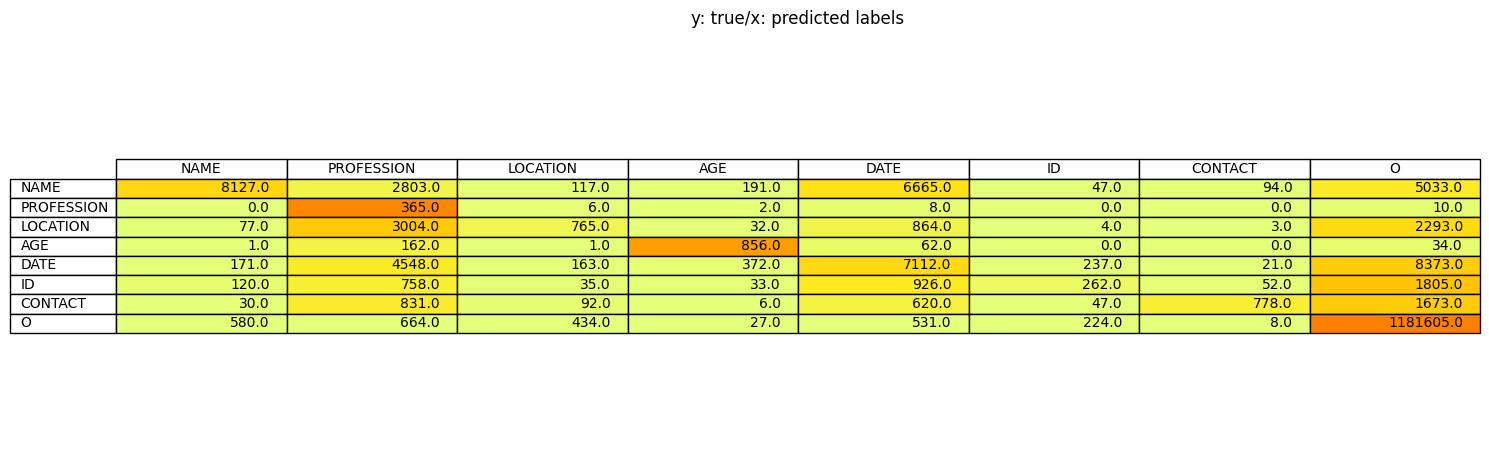

Wrongly predicted examples:
_____ Record 114-03:685 _____
| Sentence:    | dr. | philadelphia | internal medicine, | lawyer   | dd : | 1941 | dt : | mechanic | policeman |
| True labels: | O   | NAME         | O                  | LOCATION | O    | DATE | O    | DATE     | ID        |
| Sentence:    | dr. | philadelphia | internal medicine, lawyer dd : | 1941 | dt : | mechanic policeman |
| Pred labels: | O   | LOCATION     | O                              | DATE | O    | PROFESSION         |
_____ Record 193-01:467 _____
| Sentence:    | _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ | 1952 | , m. d. |
| True labels: | O                                   | NAME | O       |
| Sentence:    | _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ | 1952 | , m. d. |
| Pred labels: | O                                   | DATE | O       |
_____ Record 136-05:2074 _____
| Sentence:    | phd pgy - 2 pager # | banker  |
| True labels: | O                   | CONTACT |
| Sentence:    | phd pgy - 2 pager # banker |
| Pred la

In [18]:
# Метрики
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

In [14]:
# import importlib
# ner_metrics = importlib.import_module('utils.ner_metrics')
# ner_metrics = importlib.reload(ner_metrics)

In [19]:
stats.get_specific_failed_predictions('LOCATION')

Wrongly predicted examples:
_____ Record 166-01:780 _____
| Sentence:    | d. cc : | solicitor | , m. d. urology, | lawyer   | engineer | , m. d. | 1952     | rm 929 | solicitor | , | 1941     | policeman | / | policeman | policeman | / | philadelphia | d : | policeman policeman | t : | 1968 |
| True labels: | O       | NAME      | O                | LOCATION | NAME     | O       | LOCATION | O      | LOCATION  | O | LOCATION | NAME      | O | CONTACT   | NAME      | O | CONTACT      | O   | DATE                | O   | DATE |
| Sentence:    | d. cc : | solicitor  | , m. d. urology, | lawyer engineer | , m. d. | 1952 | rm 929 solicitor, 1941 | policeman  | / | policeman policeman | / | philadelphia | d : | policeman policeman | t : | 1968 |
| Pred labels: | O       | PROFESSION | O                | PROFESSION      | O       | DATE | O                      | PROFESSION | O | PROFESSION          | O | LOCATION     | O   | PROFESSION          | O   | DATE |
_____ Record 201-02:60 _____
| S

['110-03:714',
 '110-03:735',
 '110-03:736',
 '110-03:740',
 '110-03:741',
 '110-03:744',
 '110-03:745',
 '110-03:746',
 '110-03:747',
 '110-03:748',
 '110-03:749',
 '110-03:750',
 '110-03:751',
 '110-03:752',
 '110-03:753',
 '110-03:754',
 '110-03:755',
 '110-03:756',
 '110-03:757',
 '110-03:758',
 '110-03:759',
 '110-03:760',
 '110-03:761',
 '110-03:762',
 '110-03:763',
 '110-03:764',
 '110-03:765',
 '110-03:766',
 '110-03:767',
 '110-03:768',
 '110-03:769',
 '110-03:770',
 '110-03:771',
 '111-01:0',
 '111-02:0',
 '111-03:0',
 '112-01:0',
 '112-02:0',
 '112-02:598',
 '112-02:624',
 '112-02:625',
 '112-02:626',
 '112-02:627',
 '112-02:628',
 '112-02:629',
 '112-02:630',
 '112-02:631',
 '112-02:632',
 '112-02:633',
 '112-02:636',
 '112-02:637',
 '112-02:638',
 '112-02:639',
 '112-02:643',
 '112-02:644',
 '112-02:645',
 '112-02:646',
 '112-02:647',
 '112-02:648',
 '112-02:649',
 '112-02:650',
 '112-02:652',
 '112-03:0',
 '112-03:178',
 '112-03:238',
 '112-04:0',
 '112-04:361',
 '112-04:

In [22]:
stats.get_specific_failed_predictions('PROFESSION')

Wrongly predicted examples:
_____ Record 312-04:719 _____
| Sentence:    | he would like to try to | work       | , when he feels up to it. he lives in the | suburbs  | in | 1969     | ( a facility for homeless individuals. ) no tobacco, etoh, illicits. family history : non - contributory. exam : vitals : bp 121 / 62 hr 78 rr 16 t 97. 5 o2 sat 100 % ra gen : heent : perl, op without erythema, exudates ; mucous membranes moist ; no scleral icterus |
| True labels: | O                       | PROFESSION | O                                         | LOCATION | O  | LOCATION | O                                                                                                                                                                                                                                                                         |
| Sentence:    | he would like to try to work, when he feels up to it. he lives in the | suburbs  | in | 1969     | ( a facility for homeless individual

['114-01:358',
 '114-01:419',
 '130-04:1018',
 '130-04:1078',
 '131-04:237',
 '131-04:295',
 '134-01:180',
 '202-03:895',
 '202-03:955',
 '215-02:297',
 '215-02:358',
 '215-02:417',
 '215-03:480',
 '235-03:299',
 '235-03:359',
 '312-04:659',
 '312-04:719',
 '373-04:536',
 '373-04:596',
 '382-03:537',
 '382-03:597']

**Вывод:**  
В целом все метки предсказываются с точностью, близкой к аналогичной у первоначальных сущностей. Самое низкое качество распознавания у модели оказалось для класса 'LOCATION', предположительно, из-за слишком длинных названий больниц в используемом справочнике. Однако в первых версиях генератора синтетических данных присутствовали проблемы с меткой 'CONTACT'. Основная трудность для модели заключалась в предсказании номеров телефонов, если их генерация использовала российский стиль их написания. Тогда модель определяла его, как уникальный идентификатор. Проблема была решена сменной формата номера.  
  
Как видно, в оригинальных данных не используется код страны, и цифры сгруппированы отлично от распространённого российского варианта.  
Запись **347-03**  
Original:  (121) 537-3484  
Russian format: +1 933 257-12-32  
Запись **314-02**  
Original:  (676) 312-7662  
Russian format: +1 995 672-52-24  
  
Ещё один вариант записи номера телефона в оригинальных данных: "665-578-7821"

### Этап 2: Обучение NER на анонимизированных с помощью ILM данных из того же набора

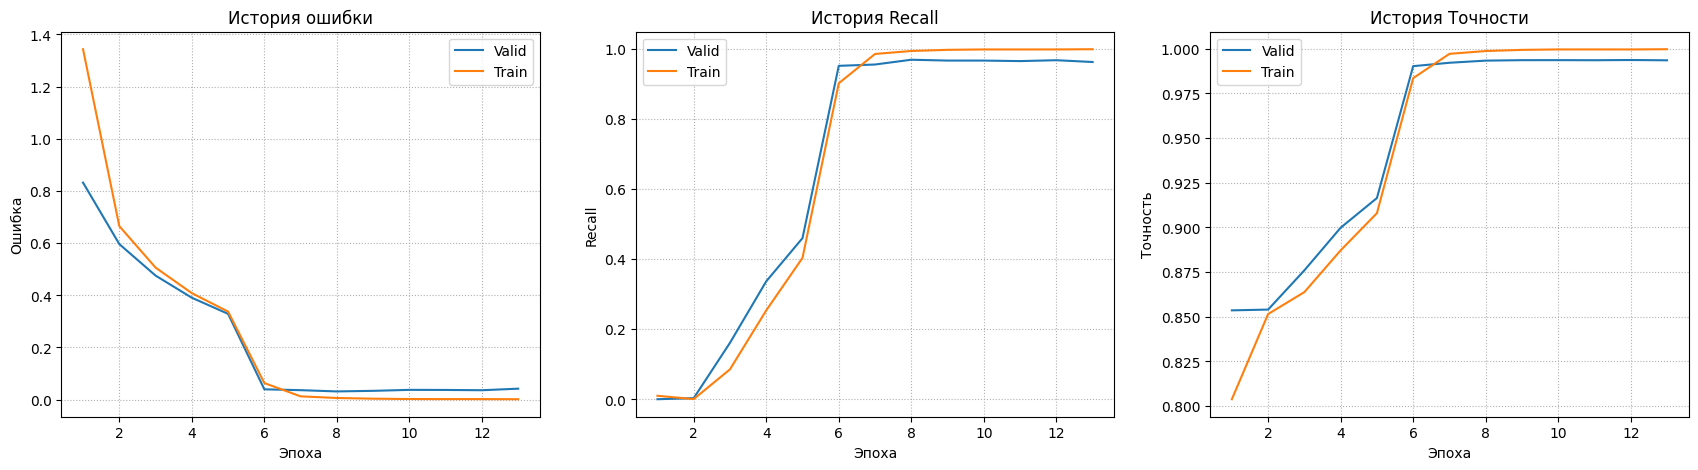

In [16]:
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_ner_tensorboard_graphics(bert_large_model_config["model_version"])

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [17]:
# Data processing
test_dataset = get_ner_dataset(path_to_folder=i2b2_2014_data_config["train_data_path"], device='cpu', **i2b2_2014_data_config)
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn(),
                             num_workers=10,
                             pin_memory=False,
                             persistent_workers=True)

Token indices sequence length is longer than the specified maximum sequence length for this model (583 > 512). Running this sequence through the model will result in indexing errors


In [18]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(bert_large_model_config["model_version"])
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.2.5, which is newer than your current Lightning version: v2.2.2


PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [19]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9930461645126343
     test_precision         0.9930461645126343
       test_recall           0.961724579334259
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.961724579334259,
  'test_precision': 0.9930461645126343,
  'test_f1': 0.9930461645126343}]

  0%|          | 0/1318 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        NAME     0.9764    0.9594    0.9678     90628
  PROFESSION     0.9645    0.5397    0.6921       856
    LOCATION     0.8701    0.8583    0.8642     17333
         AGE     0.9553    0.8545    0.9021      2028
        DATE     0.9916    0.9938    0.9927     99979
          ID     0.9507    0.9455    0.9481     20030
     CONTACT     0.9404    0.9461    0.9433     18993

   micro avg     0.9702    0.9617    0.9659    249847
   macro avg     0.9499    0.8710    0.9015    249847
weighted avg     0.9701    0.9617    0.9657    249847



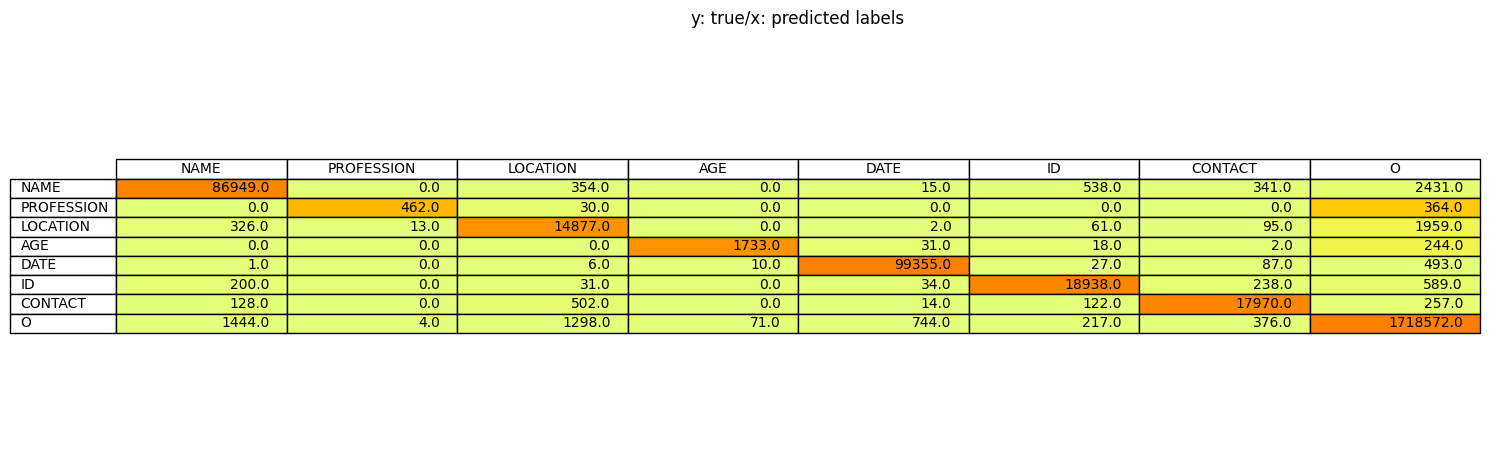

Wrongly predicted examples:
_____ Record 391-04:0 _____
| Sentence:    | record date : | 2090 - 03 - 03 | patient name : | ordonez, yamilex | [ mrn : | 0083716 | snh      | ] date of visit : | 3 / 03 / 2090 | chief complaint here for follow up of her dm, htn, cva. history of present illness reports her dm well controlled, fs usually 100 - 150, rare lows. last saw ophtamology less than 1 yr ago, will go again soon. has not |
| True labels: | O             | DATE           | O              | NAME             | O       | ID      | LOCATION | O                 | DATE          | O                                                                                                                                                                                                                        |
| Sentence:    | record date : | 2090 - 03 - 03 | patient name : | ordonez, yamilex | [ mrn : | 0083716 | snh ] date of visit : | 3 / 03 / 2090 | chief complaint here for follow up of her dm, htn, cva

In [20]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

In [21]:
stats.get_specific_failed_predictions('PROFESSION')

Wrongly predicted examples:
_____ Record 325-03:538 _____
| Sentence:    | her father. social history : the patient works as an | railway transport operations supervisor | and lives with her husband. tobacco : the patient quit smoking 10 years ago, but had an 8 - 10 pack year history prior to quitting. alcohol : the patient drinks and with no history of alcohol withdrawal or seizures. 5 - 6 beers per night on weekends with her last drink many days ago drugs : previous use of cocaine and pot in hs other : denies physical exam : vs : bp = 122 / 60 hr = |
| True labels: | O                                                    | PROFESSION                              | O                                                                                                                                                                                                                                                                                                                                      

['100-03:240',
 '106-01:600',
 '106-02:241',
 '106-02:300',
 '106-03:477',
 '106-03:537',
 '108-01:238',
 '108-02:536',
 '120-02:121',
 '120-02:180',
 '125-01:0',
 '125-02:659',
 '125-02:718',
 '125-03:717',
 '126-01:778',
 '126-02:356',
 '126-02:416',
 '126-05:655',
 '126-05:714',
 '127-03:240',
 '127-03:303',
 '127-04:481',
 '127-04:538',
 '127-05:656',
 '127-05:717',
 '141-02:598',
 '141-02:657',
 '145-02:716',
 '145-04:1011',
 '146-03:0',
 '146-04:654',
 '146-04:713',
 '147-03:419',
 '149-03:240',
 '149-03:300',
 '151-02:597',
 '151-02:656',
 '151-04:179',
 '151-04:239',
 '154-04:300',
 '154-04:360',
 '158-04:1193',
 '158-04:1252',
 '170-04:482',
 '170-05:241',
 '174-05:360',
 '174-05:418',
 '175-03:480',
 '177-04:1372',
 '179-03:418',
 '179-04:1318',
 '187-01:656',
 '187-03:1309',
 '187-03:1369',
 '187-04:1547',
 '188-02:119',
 '188-02:178',
 '220-04:776',
 '220-04:836',
 '220-05:777',
 '223-02:117',
 '223-02:177',
 '223-03:237',
 '223-03:299',
 '223-04:178',
 '223-04:234',
 '224-

In [22]:
stats.get_specific_failed_predictions('CONTACT')

Wrongly predicted examples:
_____ Record 292-05:1374 _____
| Sentence:    | by : | yisroel f cooley | , md mph frcpc email : | yfcooley @ wsh. org |
| True labels: | O    | NAME             | O                      | CONTACT             |
| Sentence:    | by : | yisroel f cooley | , md mph | frcpc    | email : | yfcooley | @ | wsh      | . org |
| Pred labels: | O    | NAME             | O        | LOCATION | O       | NAME     | O | LOCATION | O     |
_____ Record 148-04:1316 _____
| Sentence:    | will hold plavix and asa in event of operative procedure | rsh      | surgery | welsh general hospital humana hospital ville platte | 294 | 942 077 9578 |
| True labels: | O                                                        | LOCATION | O       | LOCATION                                            | O   | CONTACT      |
| Sentence:    | will hold plavix and asa in event of operative procedure | rsh surgery welsh general hospital humana hospital ville platte 294 942 077 9578 |
| Pred la

['100-04:1080',
 '100-04:1081',
 '105-05:1614',
 '107-04:357',
 '107-04:376',
 '107-04:377',
 '107-04:378',
 '107-04:379',
 '107-04:380',
 '107-04:381',
 '107-04:382',
 '107-04:383',
 '107-04:384',
 '107-04:385',
 '107-04:386',
 '107-04:387',
 '107-04:388',
 '107-04:389',
 '107-04:390',
 '107-04:391',
 '107-04:392',
 '107-04:393',
 '107-04:396',
 '107-04:398',
 '107-04:399',
 '107-04:401',
 '107-04:402',
 '107-04:405',
 '107-04:409',
 '107-04:410',
 '107-04:413',
 '107-04:414',
 '145-03:1331',
 '148-03:2189',
 '148-04:1314',
 '148-04:1315',
 '148-04:1316',
 '148-04:1317',
 '148-04:1318',
 '148-04:1321',
 '148-04:1322',
 '148-04:1323',
 '148-04:1327',
 '148-04:1328',
 '148-04:1330',
 '148-04:1331',
 '148-04:1332',
 '148-04:1333',
 '148-04:1334',
 '148-04:1336',
 '149-03:1076',
 '149-03:1115',
 '149-03:1116',
 '149-03:1120',
 '149-03:1121',
 '149-03:1124',
 '149-03:1125',
 '149-03:1126',
 '149-03:1127',
 '149-03:1128',
 '149-03:1129',
 '149-03:1130',
 '149-03:1131',
 '149-03:1132',
 '149

**Вывод:**  
Заметим, что из-за малого разнообразия формата данных наблюдается переобучение модели после $6$-ой эпохи. Также общее качество работы модели заметно уменьшилось до Recall $=78.71\%$. При этом модель часто принимала класс 'ID' за 'CONTACT', так как искусственно сгенерированные идентификаторы представляют собой непрерываемый поток цифр. Самое же большое падение качества наблюдается в распознавании идентификаторов и имён. Приведём примеры их ошибок, связанных в основном с малым количеством форматов у синтетических данных:

### Этап 3: Обучение NER на анонимизированных с помошью ILM данных из другого набора в том же домене

In [23]:
# Data processing
test_dataset = get_ner_dataset(path_to_folder=i2b2_2006_data_config["validate_data_path"], device='cpu', **i2b2_2006_data_config)
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2006_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn(),
                             num_workers=10,
                             pin_memory=False,
                             persistent_workers=True)

Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors


In [24]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9469935297966003
     test_precision         0.9469935297966003
       test_recall          0.8698998093605042
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.8698998093605042,
  'test_precision': 0.9469935297966003,
  'test_f1': 0.9469935297966003}]

  0%|          | 0/346 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        NAME     0.9387    0.8619    0.8987     31938
  PROFESSION     0.0000    0.0000    0.0000         0
    LOCATION     0.8586    0.7620    0.8074      8085
         AGE     0.0123    0.5000    0.0240        10
        DATE     0.5668    0.9943    0.7220     21502
          ID     0.9430    0.7103    0.8103     11178
     CONTACT     0.5831    0.9521    0.7233      2921

   micro avg     0.7490    0.8699    0.8049     75634
   macro avg     0.5575    0.6829    0.5694     75634
weighted avg     0.8112    0.8699    0.8187     75634



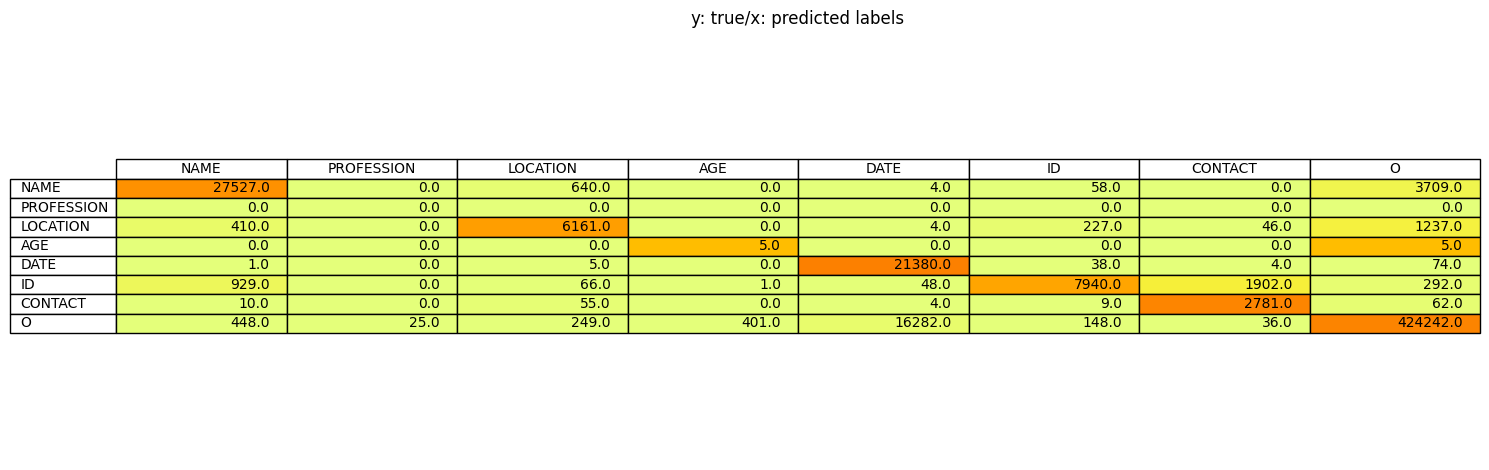

Wrongly predicted examples:
_____ Record 635:1130 _____
| Sentence:    | 1998 td : | 12 / 08 | / 1998 11 : 39 a cc : emergency assoc trauma [ report _ end ] |
| True labels: | O         | DATE    | O                                                             |
| Sentence:    | 1998 | td : | 12 / 08 / 1998 | 11 : 39 a cc : emergency assoc trauma [ report _ end ] |
| Pred labels: | DATE | O    | DATE           | O                                                      |
_____ Record 527:295 _____
| Sentence:    | . the patient now presents for line 1, cycle 4 to 15 of vp 16 and cisplatin chemotherapy. past medical history : the patient's past medical history is unremarkable. past surgical history : as above, including an embolectomy in | june | 1992. medications on admission : coumadin 2. 5 mg. five times a week, ativan and lomotil prn. adverse drug reactions : no known drug allergies, but has shellfish allergy |
| True labels: | O                                                          

In [25]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

In [26]:
stats.get_specific_failed_predictions('LOCATION')

Wrongly predicted examples:
_____ Record 602:1700 _____
| Sentence:    | 763 - 1448 | thesa health no rockford birmton | [ report _ end ] |
| True labels: | CONTACT    | LOCATION                         | O                |
| Sentence:    | 763 - 1448 thesa health | no | rockford birmton | [ report _ end ] |
| Pred labels: | LOCATION                | O  | LOCATION         | O                |
_____ Record 630:180 _____
| Sentence:    | a chest x - ray revealing a patchy infiltrate in the right lung. she was treated with clindamycin and erythromycin which were changed to trovan and then transferred to | a hospital | . on | may 27 | , 1998, the patient desaturated to 40 % with a temperature of 100. 5 degrees. her oxygen saturations improved to only 92 % on 100 % face mask and she was admitted to | pre health | intensive care unit. chest x - ray there revealed bilateral |
| True labels: | O                                                                                                    

['111:0',
 '111:662',
 '135:0',
 '151:0',
 '151:60',
 '168:0',
 '168:1257',
 '177:0',
 '177:119',
 '177:1373',
 '185:0',
 '185:1253',
 '185:1306',
 '185:1307',
 '185:1313',
 '185:1317',
 '185:1318',
 '185:1319',
 '185:1320',
 '185:1321',
 '185:1322',
 '185:1337',
 '185:180',
 '185:240',
 '194:0',
 '194:120',
 '194:180',
 '194:595',
 '194:655',
 '202:0',
 '202:1433',
 '202:237',
 '202:297',
 '206:0',
 '214:0',
 '214:480',
 '220:0',
 '220:60',
 '233:0',
 '420:0',
 '420:302',
 '420:360',
 '420:60',
 '420:839',
 '422:1610',
 '422:1670',
 '422:1694',
 '422:1696',
 '422:1697',
 '422:1698',
 '422:1701',
 '422:1702',
 '422:1703',
 '422:1705',
 '422:1706',
 '422:1707',
 '422:1708',
 '422:1709',
 '422:1710',
 '422:1712',
 '422:1714',
 '422:1715',
 '422:1716',
 '422:1720',
 '422:1721',
 '422:1723',
 '422:1725',
 '423:0',
 '424:0',
 '424:60',
 '428:333',
 '429:0',
 '429:418',
 '429:476',
 '430:0',
 '430:60',
 '431:0',
 '431:1313',
 '431:1371',
 '431:60',
 '436:0',
 '436:60',
 '438:0',
 '438:60',
 

In [27]:
stats.get_specific_failed_predictions('ID')

Wrongly predicted examples:
_____ Record 420:1005 _____
| Sentence:    | d. ( | ah29 | ) | 06 / 09 | / 04 07 : 22 pm * * * * * * end of discharge orders * * * * * * [ report _ end ] |
| True labels: | O    | ID   | O | DATE    | O                                                                                |
| Sentence:    | d. ( | ah29 | ) | 06 / 09 / 04 | 07 : 22 pm * * * * * * end of discharge orders * * * * * * [ report _ end ] |
| Pred labels: | O    | NAME | O | DATE         | O                                                                           |
_____ Record 510:0 _____
| Sentence:    | 405507617 | fih      | 2887168 132052 543394 | 11 / 12 | / 2002 12 : 00 : 00 am discharge summary unsigned dis report status : unsigned discharge summary name : | spaldfreiermplca, ieoly e | unit number : | 251 - 62 - 95 | admission date : | 11 / 12 | / 2002 discharge date : | 11 / 15 | / 2002 principal diagnosis : alzheimer's disease secondary to down's syndrome. chief complaint : this 

['111:1197',
 '111:1316',
 '111:1317',
 '135:1610',
 '135:1670',
 '135:1720',
 '135:1721',
 '135:1723',
 '151:0',
 '151:60',
 '151:837',
 '151:866',
 '151:867',
 '151:868',
 '151:869',
 '151:870',
 '151:871',
 '151:874',
 '168:0',
 '168:2421',
 '168:2428',
 '168:2429',
 '168:2430',
 '168:2432',
 '168:2433',
 '168:2434',
 '168:2435',
 '168:2436',
 '168:2437',
 '168:2438',
 '168:2439',
 '177:0',
 '177:1612',
 '177:1636',
 '177:1637',
 '177:1638',
 '177:1639',
 '177:1640',
 '177:1641',
 '177:1642',
 '177:1643',
 '177:1644',
 '177:1645',
 '177:1646',
 '177:1647',
 '177:1648',
 '177:1649',
 '177:1650',
 '177:1651',
 '194:0',
 '194:60',
 '206:715',
 '206:775',
 '206:832',
 '206:833',
 '206:836',
 '206:837',
 '206:838',
 '206:840',
 '206:841',
 '206:842',
 '206:843',
 '214:0',
 '214:60',
 '220:0',
 '220:60',
 '220:718',
 '220:778',
 '220:805',
 '220:806',
 '220:807',
 '220:808',
 '220:809',
 '220:812',
 '233:0',
 '233:1421',
 '233:1422',
 '233:60',
 '420:0',
 '420:1002',
 '420:1003',
 '420:10

**Вывод:**  
Заметим, что из-за малого разнообразия формата данных наблюдается переобучение модели после $6$-ой эпохи. Также общее качество работы модели заметно уменьшилось до Recall $=78.71\%$. При этом модель часто принимала класс 'ID' за 'CONTACT', так как искусственно сгенерированные идентификаторы представляют собой непрерываемый поток цифр. Самое же большое падение качества наблюдается в распознавании идентификаторов и имён. Приведём примеры их ошибок, связанных в основном с малым количеством форматов у синтетических данных:

In [6]:
import numpy as np
a = np.array([0.005988, 0.633999, 0.031310, 0.267605, 0.005428, 0.027095, 0.028574])
b = 1 / a / (1/a).sum()
(a * b * 65.77).sum()

1.0000055737409304